In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import nibabel as nib
import os
import random
from pathlib import Path

HGG_path = Path(os.path.expanduser("~/CV_project_MRI/data/MICCAI_BraTS_2019_Data_Training/HGG/"))
LGG_path = Path(os.path.expanduser("~/CV_project_MRI/data/MICCAI_BraTS_2019_Data_Training/LGG/"))

In [ ]:
!wget https://blent-learning-user-ressources.s3.eu-west-3.amazonaws.com/projects/60fb61/brats_2019.zip 
!unzip -q brats_2019.zip -d ~/CV_project_MRI/data/

# Dataset exploration

In [ ]:

# Load NIfTI file
img = nib.load(os.path.join(HGG_path, "BraTS19_2013_2_1/BraTS19_2013_2_1_flair.nii"))
data = img.get_fdata()
data.shape



(240, 240, 155)

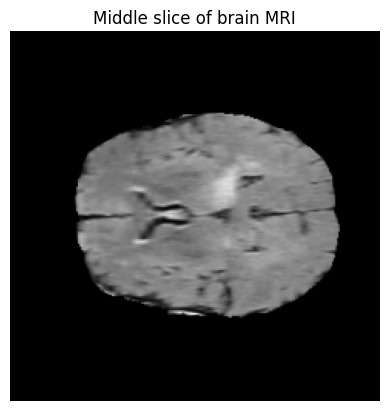

In [ ]:

# Plot a slice
plt.imshow(data[:, :, 80], cmap="gray") # coupe selon z=80 -> faire une video avec toutes les hauteurs? Couper selon les autres axes? 
plt.title("Middle slice of brain MRI")
plt.axis("off")
plt.show()

[PosixPath('/Users/kraligan/CV_project_MRI/data/MICCAI_BraTS_2019_Data_Training/HGG/BraTS19_TCIA01_401_1'), PosixPath('/Users/kraligan/CV_project_MRI/data/MICCAI_BraTS_2019_Data_Training/HGG/BraTS19_TCIA02_608_1'), PosixPath('/Users/kraligan/CV_project_MRI/data/MICCAI_BraTS_2019_Data_Training/HGG/BraTS19_CBICA_AXO_1'), PosixPath('/Users/kraligan/CV_project_MRI/data/MICCAI_BraTS_2019_Data_Training/HGG/BraTS19_CBICA_AQD_1'), PosixPath('/Users/kraligan/CV_project_MRI/data/MICCAI_BraTS_2019_Data_Training/HGG/BraTS19_CBICA_AOD_1'), PosixPath('/Users/kraligan/CV_project_MRI/data/MICCAI_BraTS_2019_Data_Training/HGG/BraTS19_TCIA04_328_1'), PosixPath('/Users/kraligan/CV_project_MRI/data/MICCAI_BraTS_2019_Data_Training/HGG/BraTS19_TCIA03_338_1'), PosixPath('/Users/kraligan/CV_project_MRI/data/MICCAI_BraTS_2019_Data_Training/HGG/BraTS19_TCIA02_179_1'), PosixPath('/Users/kraligan/CV_project_MRI/data/MICCAI_BraTS_2019_Data_Training/HGG/BraTS19_CBICA_AQP_1'), PosixPath('/Users/kraligan/CV_project_MR

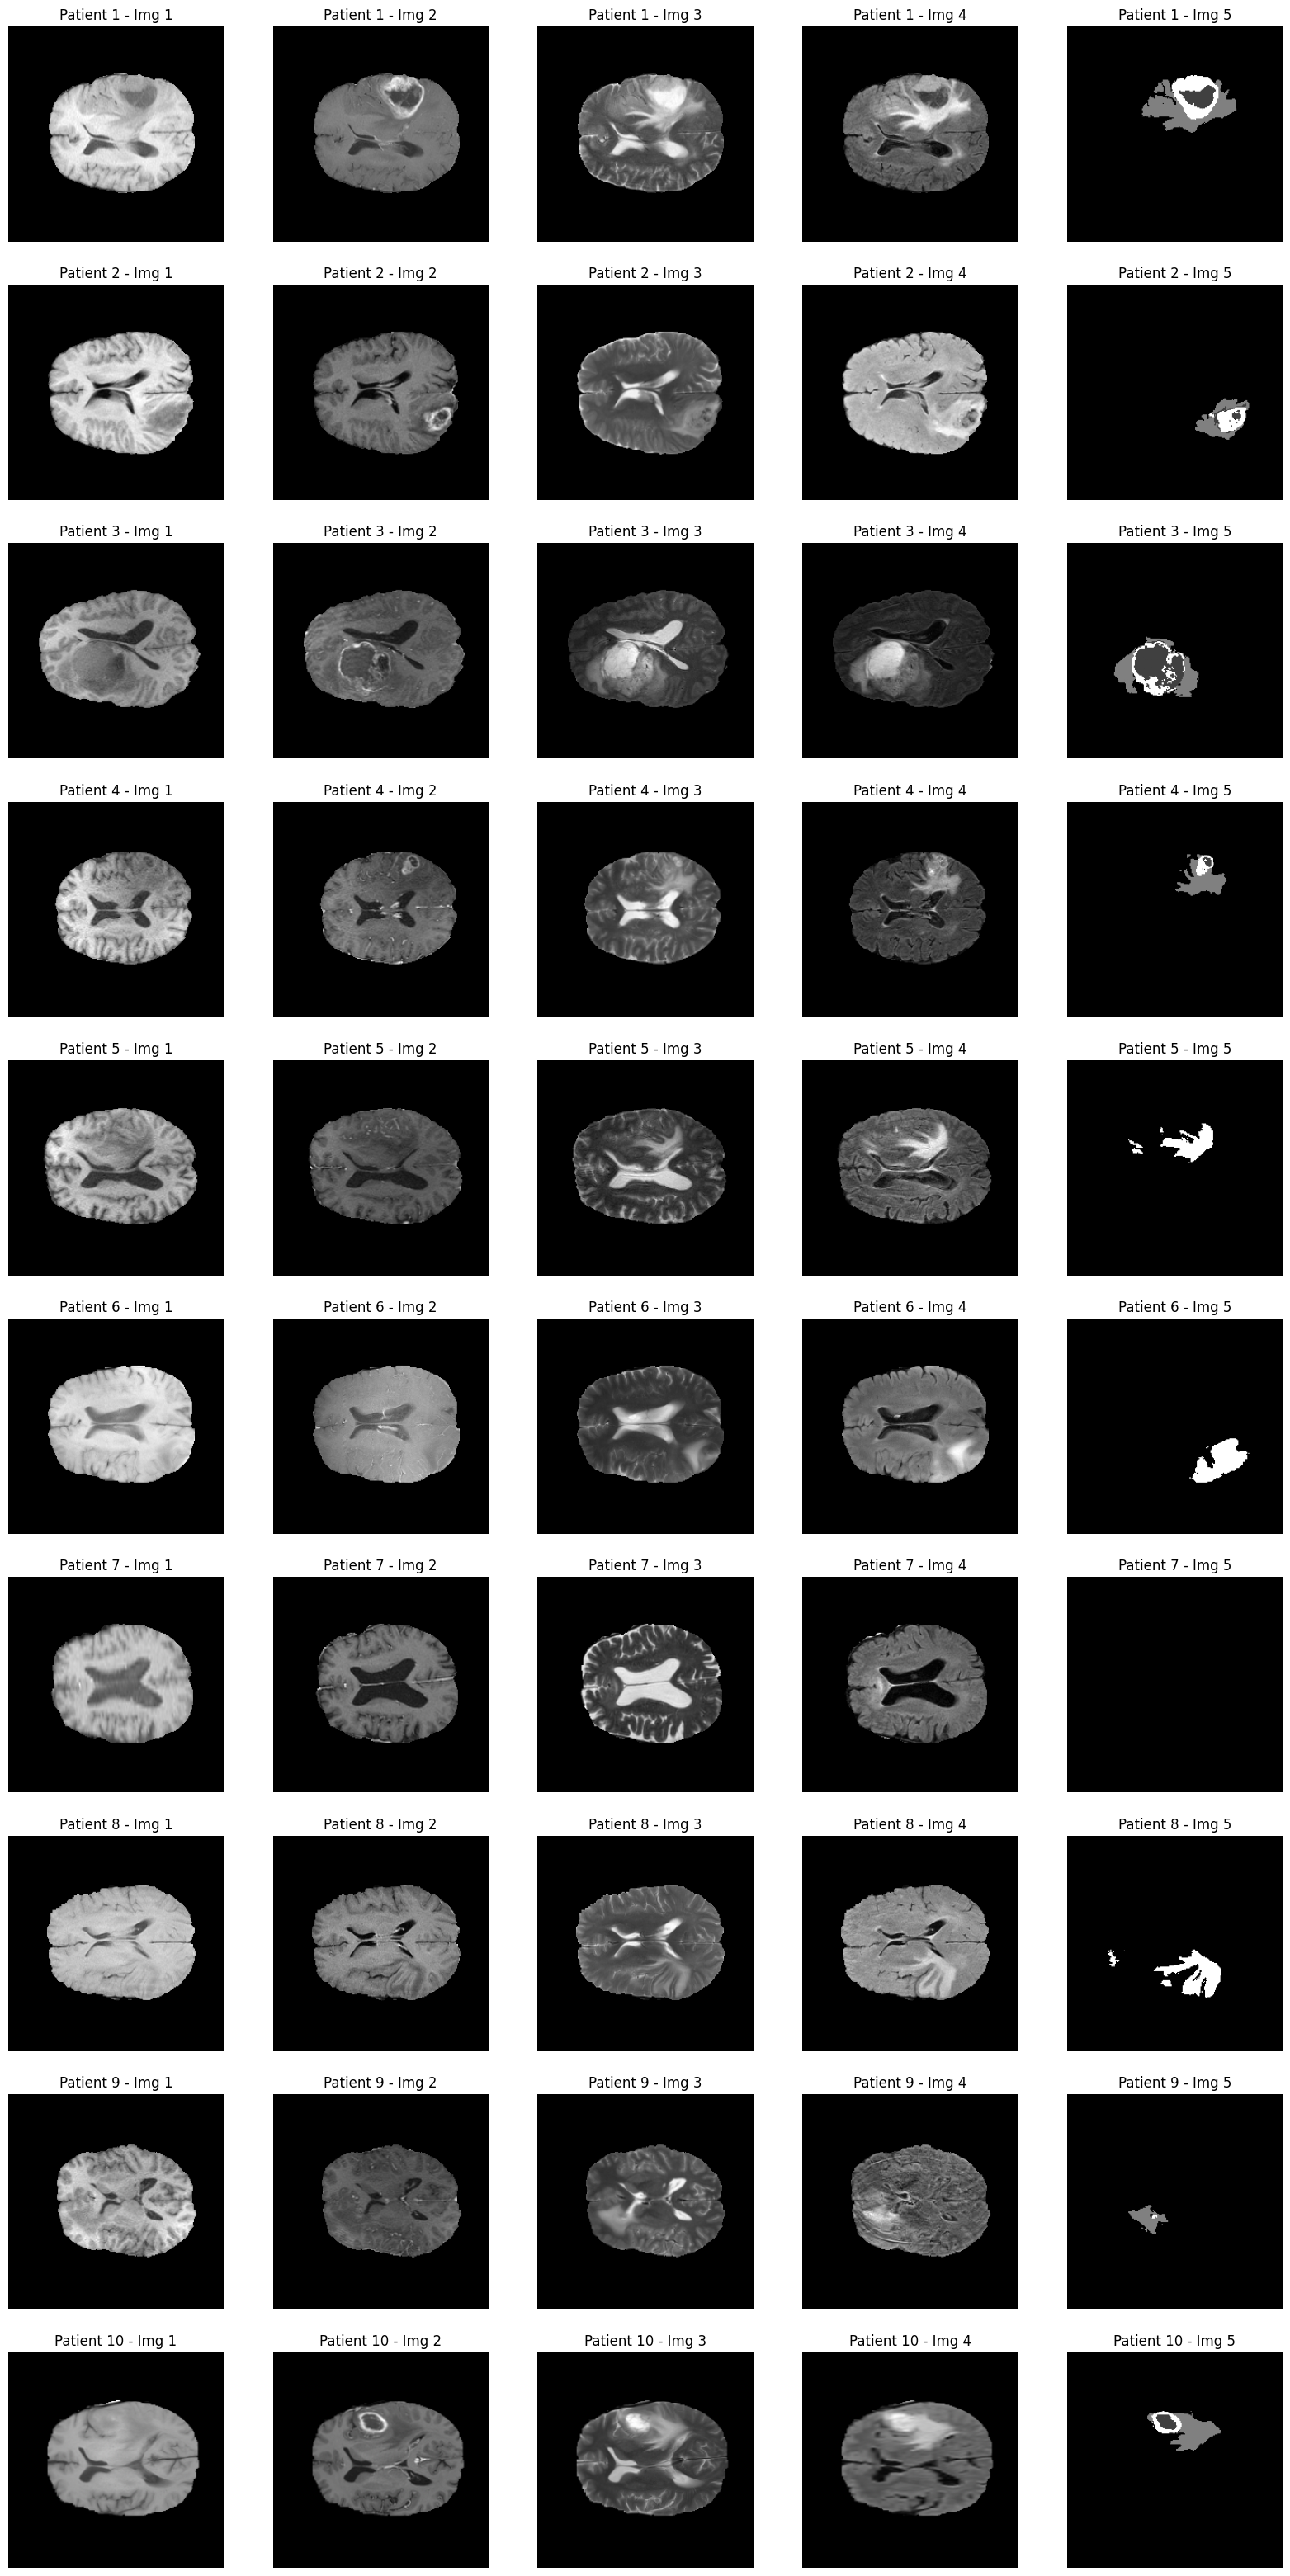

In [38]:

imgs = []

# selectionner x patients au hasard
x = 10
patients = [p for p in HGG_path.iterdir() if p.is_dir()]
sampled_patients = random.sample(patients, x)
print(sampled_patients)

# Boucle sur les x patients
for patient in sampled_patients:
    print(patient.name)
    T1 = nib.load(f"{HGG_path}/{patient.name}/{patient.name}_t1.nii")
    T1CE = nib.load(f"{HGG_path}/{patient.name}/{patient.name}_t1ce.nii")
    T2 = nib.load(f"{HGG_path}/{patient.name}/{patient.name}_t2.nii")
    FLAIR = nib.load(f"{HGG_path}/{patient.name}/{patient.name}_flair.nii")
    SEG = nib.load(f"{HGG_path}/{patient.name}/{patient.name}_seg.nii")
    imgs.append([T1, T1CE, T2, FLAIR, SEG])


# Plot a slice
fig, axes = plt.subplots(x, 5, figsize=(20, x*4))  # x rows, 5 columns

for i, patient in enumerate(imgs):
    for j, img in enumerate(patient):
        data = img.get_fdata()
        ax = axes[i, j]
        ax.imshow(data[:, :, 80], cmap="gray")
        ax.set_title(f"Patient {i+1} - Img {j+1}")
        ax.axis("off")


# Pre rocessing
Nous avons des images en 240x240x155 et nous souhaitons les redimensionner en 240x240x144 (sans alterer les dimensions). \
Nous constatons que sur les grande majorite des images, le cerveau s'arrete a 147 pixels et commence a 3 pixels (sur l'axe z). \
Nous allons donc supprimer les 3 premieres couches ainsi que les 8 dernieres pour supprimer les couches vides et ainsi obtenir des parrallelepipedes de 240x240x144.

In [19]:
data = data[:,:,3:147]
data.shape

(240, 240, 141)

- Appliquer ce filtre sur toutes les images flair et segmentation \
- extraire toutes les images flair/seg redimensionnées dans un dossier sous la forme: \
 dataset_UNET/ \
 | \
 |- X \
 |   |- {patient_ID}_flair.nii  \
 |   |... \
 |- Y \
 |   |- {patient_ID}_seg.nii  \
 |   |... \
 |- label.csv -> (patient_ID, grade) pour realiser la classification \
\
(- Regrouper les deux fichiers csv et ne garder que les colonnes: grade, ID_2019, age, survival, ResectionStatus)\
   -> Les fichiers csv sont ils utiles dans notre cas? Servent-ils uniquement dans un cas ou on souhaite entrainer \
   un model de ML pour faire de la predicitions de cancer ou autre, mais pas dans notre cas de detection de tumeur par computer vision? 
\
Le dossier dataset nous servira de base pour entrainer le model UNET

In [ ]:
output_X = Path("~/CV_project_MRI/data/MICCAI_BraTS_2019_Data_Training/dataset_UNET/X").expanduser()
output_Y = Path("~/CV_project_MRI/data/MICCAI_BraTS_2019_Data_Training/dataset_UNET/Y").expanduser()

output_X.mkdir(parents=True, exist_ok=True)
output_Y.mkdir(parents=True, exist_ok=True)

patients_HGG = [p for p in HGG_path.iterdir() if p.is_dir()]
patients_LGG = [p for p in LGG_path.iterdir() if p.is_dir()]

for patient in patients_HGG:
    try:
        flair_path = patient / f"{patient.name}_flair.nii"
        seg_path   = patient / f"{patient.name}_seg.nii"

        # Chargement et crop Z
        flair_data = nib.load(flair_path).get_fdata()[:, :, 3:147]
        seg_data   = nib.load(seg_path).get_fdata()[:, :, 3:147]

        # Sauvegarde des .nii.gz cropped
        flair_img = nib.Nifti1Image(flair_data, affine=np.eye(4))  # ajouter une affine minimale
        seg_img   = nib.Nifti1Image(seg_data, affine=np.eye(4))

        nib.save(flair_img, output_X / f"{patient.name}_flair.nii.gz")
        nib.save(seg_img,   output_Y / f"{patient.name}_seg.nii.gz")

    except Exception as e:
        print(f"Erreur avec {patient.name}: {e}")

for patient in patients_LGG:
    try:
        flair_path = patient / f"{patient.name}_flair.nii"
        seg_path   = patient / f"{patient.name}_seg.nii"

        # Chargement et crop Z
        flair_data = nib.load(flair_path).get_fdata()[:, :, 3:147]
        seg_data   = nib.load(seg_path).get_fdata()[:, :, 3:147]

        # Sauvegarde des .nii.gz cropped
        flair_img = nib.Nifti1Image(flair_data, affine=np.eye(4))  # ajouter une affine minimale
        seg_img   = nib.Nifti1Image(seg_data, affine=np.eye(4))

        nib.save(flair_img, output_X / f"{patient.name}_flair.nii.gz")
        nib.save(seg_img,   output_Y / f"{patient.name}_seg.nii.gz")

    except Exception as e:
        print(f"Erreur avec {patient.name}: {e}")

## Save Dataset 2D dans un format .npy injectable dans tensorflow
(Avec le dossier X contenant toutes les couches (suivant z) de toutes les images flair, et Y contenant toutes les couches de toutes les images seg)

In [39]:
import numpy as np
import nibabel as nib
from pathlib import Path

input_X = Path("~/CV_project_MRI/data/MICCAI_BraTS_2019_Data_Training/dataset_UNET/X").expanduser()
input_Y = Path("~/CV_project_MRI/data/MICCAI_BraTS_2019_Data_Training/dataset_UNET/Y").expanduser()
output_X = Path("~/CV_project_MRI/data/MICCAI_BraTS_2019_Data_Training/dataset_UNET_2D/X").expanduser()
output_Y = Path("~/CV_project_MRI/data/MICCAI_BraTS_2019_Data_Training/dataset_UNET_2D/Y").expanduser()

output_X.mkdir(parents=True, exist_ok=True)
output_Y.mkdir(parents=True, exist_ok=True)

for flair_file, seg_file in zip(input_X.glob("*.nii.gz"), input_Y.glob("*.nii.gz")):
    patient_id_flair = flair_file.name.split("_flair")[0]
    patient_id_seg = seg_file.name.split("_seg")[0]

    flair_data = nib.load(flair_file).get_fdata()
    seg_data = nib.load(seg_file).get_fdata()

    # slice par axe Z
    for i in range(flair_data.shape[2]):
        img_slice = flair_data[:, :, i]
        seg_slice = seg_data[:, :, i]

        # Enregistrer slice 2D comme .npy
        np.save(output_X / f"{patient_id_flair}_slice_{i:03}.npy", img_slice)
        np.save(output_Y / f"{patient_id_seg}_slice_{i:03}.npy", seg_slice)

# Training

## UNET

### Creation Dataset

In [40]:
import tensorflow as tf
import numpy as np
import glob

X_paths = sorted(glob.glob(os.path.expanduser("~/CV_project_MRI/data/MICCAI_BraTS_2019_Data_Training/dataset_UNET_2D/X/*.npy")))
Y_paths = sorted(glob.glob(os.path.expanduser("~/CV_project_MRI/data/MICCAI_BraTS_2019_Data_Training/dataset_UNET_2D/Y/*.npy")))

def load_npy_pair(x_path, y_path):
    x = np.load(x_path.decode()).astype(np.float32)
    y = np.load(y_path.decode()).astype(np.float32)

    # Normalisation min-max slice par slice
    if x.max() > 0:  # éviter division par zéro
        x = x / x.max()

    x = np.expand_dims(x, axis=-1)  # (240, 240, 1)
    y = np.expand_dims(y, axis=-1)
    return x, y

def tf_wrapper(x_path, y_path):
    return tf.numpy_function(load_npy_pair, [x_path, y_path], [tf.float32, tf.float32])

# Fonction de construction du dataset
def make_dataset(data_pairs, batch_size=8):
    X, Y = zip(*data_pairs)
    ds = tf.data.Dataset.from_tensor_slices((list(X), list(Y)))
    ds = ds.map(tf_wrapper)
    ds = ds.shuffle(100)
    ds = ds.batch(batch_size)
    ds = ds.prefetch(tf.data.AUTOTUNE) # pipeline asynchrone optimisé
    return ds



### Creation model

In [41]:
import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, BatchNormalization, Dropout, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.activations import relu
from tensorflow.keras.utils import to_categorical
from keras import backend as K

def encoding_layer(input_layer,output_channels,kernel_size):
    conv1 = Conv2D(output_channels, (kernel_size, kernel_size), activation='relu', padding='same',\
                   kernel_initializer=tf.random_normal_initializer(0, 0.02)) (input_layer)
    return conv1

def bottleneck(input_layer,output_channels,kernel_size):
    bottleneck1 = Conv2D(output_channels, (kernel_size, kernel_size), activation='relu', padding='same',\
                         kernel_initializer=tf.random_normal_initializer(0, 0.02)) (input_layer)
    bottleneck2 = Conv2D(output_channels, (kernel_size, kernel_size), activation='relu', padding='same',\
                         kernel_initializer=tf.random_normal_initializer(0, 0.02)) (bottleneck1)
    return bottleneck2

def decoding_layer(input_layer,skip_layer,output_channels,kernel_size,stride):
    upconv1 = Conv2DTranspose(output_channels,  (kernel_size, kernel_size),strides=(stride,stride), padding='same',\
                              kernel_initializer=tf.random_normal_initializer(0, 0.02)) (input_layer)
    concat1 = concatenate([upconv1, skip_layer])
    conv1 = Conv2D(output_channels, kernel_size, activation='relu', padding='same',\
                   kernel_initializer=tf.random_normal_initializer(0, 0.02)) (concat1)
    return conv1

def create_unet(input_shape=(240,240,1), num_classes=4):
    inputs_coarse = Input(input_shape)

    encoding_layer1=encoding_layer(inputs_coarse,64,3)
    pool1 = MaxPooling2D((2, 2),padding='same') (encoding_layer1)
    encoding_layer2=encoding_layer(pool1,128,3)
    pool2 = MaxPooling2D((2, 2),padding='same') (encoding_layer2)
    encoding_layer3=encoding_layer(pool2,256,3)
    pool3 = MaxPooling2D((2, 2),padding='same') (encoding_layer3)
    encoding_layer4=encoding_layer(pool3,512,3)
    pool4 = MaxPooling2D((2, 2),padding='same') (encoding_layer4)

    bottleneck=bottleneck(pool4,1024,3)

    decoding_layer1= decoding_layer(bottleneck,encoding_layer4,512,3,1)
    decoding_layer2= decoding_layer(decoding_layer1,encoding_layer3,256,3,1)
    decoding_layer3 = decoding_layer(decoding_layer2,encoding_layer2,128,3,2)
    decoding_layer4 = decoding_layer(decoding_layer3,encoding_layer1,64,3,2)

    outputs = Conv2D(num_classes, (1, 1), activation='softmax') (decoding_layer4)

    model = Model(inputs=inputs_coarse, outputs=[outputs])
    optim=Adam(learning_rate=0.0001)
    model.compile(optimizer=optim, loss=['sparse_categorical_crossentropy'], metrics=['accuracy'])
    model.summary()

### Training avec Tensorboard

In [ ]:
# Lancer dans un terminal la commande: tensorboard --logdir "./logs"

from tensorflow.keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint
import os

EPOCH = 10
BATCH_SIZE = 8

Serving TensorBoard on localhost; to expose to the network, use a proxy or pass --bind_all
TensorBoard 2.19.0 at http://localhost:6006/ (Press CTRL+C to quit)
^C


In [ ]:

model = create_unet()
tensorboard_callback_unet = TensorBoard(log_dir=os.path.expanduser("~CV_project_MRI/logs/unet"))

# Creation du dataset

## Créer les paires
data = list(zip(X_paths, Y_paths))
random.shuffle(data)

## Split Dataset Train, Val, Test
n = len(data)
train_data = data[:int(0.7*n)]
val_data   = data[int(0.7*n):int(0.9*n)]
test_data  = data[int(0.9*n):]

train_ds = make_dataset(train_data, batch_size=BATCH_SIZE)
val_ds   = make_dataset(val_data, batch_size=BATCH_SIZE)
test_ds  = make_dataset(test_data, batch_size=BATCH_SIZE)


In [ ]:

model.fit(
    train_ds, 
    validation_data=val_ds,
    epochs=EPOCH,
    callbacks=[
        tensorboard_callback_unet, 
        EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
        ModelCheckpoint("checkpoints/unet_best.h5", monitor='val_loss', save_best_only=True)
        ]
)


In [ ]:
model.evaluate(test_ds)